In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '55-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


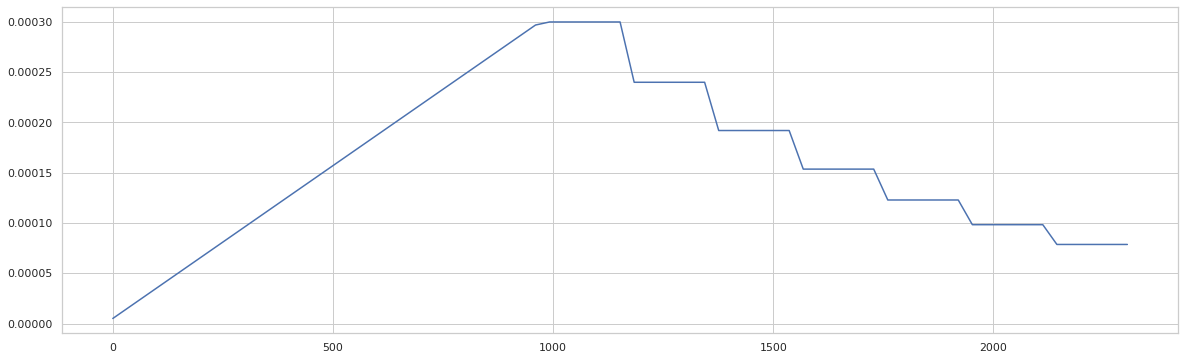

In [11]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [14]:
# Initial bias

pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print(pos)
print(neg)
print(initial_bias)

584
32542
[-4.02038586]


In [17]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [18]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(         lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
194/194 - 37s - auc: 0.6413 - loss: 0.1756 - val_auc: 0.6870 - val_loss: 0.1742
Epoch 2/12
194/194 - 24s - auc: 0.8347 - loss: 0.1675 - val_auc: 0.8156 - val_loss: 0.1664
Epoch 3/12
194/194 - 25s - auc: 0.8521 - loss: 0.1663 - val_auc: 0.8474 - val_loss: 0.1652
Epoch 4/12
194/194 - 23s - auc: 0.8678 - loss: 0.1661 - val_auc: 0.8228 - val_loss: 0.1672
Epoch 5/12
194/194 - 23s - auc: 0.8730 - loss: 0.1635 - val_auc: 0.7788 - val_loss: 0.1674
Epoch 6/12
194/194 - 24s - auc: 0.8829 - loss: 0.1627 - val_auc: 0.8252 - val_loss: 0.1650
Epoch 7/12
194/194 - 23s - auc: 0.9038 - loss: 0.1605 - val_auc: 0.8540 - val_loss: 0.1673
Epoch 8/12
194/194 - 23s - auc: 0.9217 - loss: 0.1566 - val_auc: 0.8212 - val_loss: 0.1656
Epoch 9/12
194/194 - 25s - auc: 0.9311 - loss: 0.1555 - val_auc: 0.8589 - val_loss: 0.1643
Epoch 10/12
194/194 - 23s - auc: 0.9349 - loss: 0.1542 - val_auc: 0.8587 - val_loss: 0.1643
Epoch 11/12
194/194 - 23s - auc: 0.9564 - loss: 0.1500 - val_auc: 0.8393 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 38s - auc: 0.6633 - loss: 0.1738 - val_auc: 0.6734 - val_loss: 0.1756
Epoch 2/12
210/210 - 26s - auc: 0.8375 - loss: 0.1672 - val_auc: 0.8274 - val_loss: 0.1682
Epoch 3/12
210/210 - 26s - auc: 0.8569 - loss: 0.1660 - val_auc: 0.8362 - val_loss: 0.1666
Epoch 4/12
210/210 - 24s - auc: 0.8766 - loss: 0.1645 - val_auc: 0.8134 - val_loss: 0.1699
Epoch 5/12
210/210 - 26s - auc: 0.8717 - loss: 0.1628 - val_auc: 0.8416 - val_loss: 0.1655
Epoch 6/12
210/210 - 26s - auc: 0.8985 - loss: 0.1622 - val_auc: 0.8773 - val_loss: 0.1637
Epoch 7/12
210/210 - 26s - auc: 0.9095 - loss: 0.1573 - val_auc: 0.8831 - val_loss: 0.1629
Epoch 8/12
210/210 - 24s - auc: 0.9240 - loss: 0.1557 - val_auc: 0.8555 - val_loss: 0.1633
Epoch 9/12
210/210 - 24s - auc: 0.9405 - loss: 0.1543 - val_auc: 0.8751 - val_loss: 0.1638
Epoch 10/12
210/210 - 24s - auc: 0.9515 - loss: 0.1515 - val_auc: 0.8666 - val_loss: 0.1646
Epoch 11/12
210/210 - 24s - auc: 0.9496 - loss: 0.1490 - val_auc: 0.8795 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - auc: 0.6559 - loss: 0.1755 - val_auc: 0.7033 - val_loss: 0.1787
Epoch 2/12
210/210 - 26s - auc: 0.8426 - loss: 0.1661 - val_auc: 0.8586 - val_loss: 0.1677
Epoch 3/12
210/210 - 24s - auc: 0.8554 - loss: 0.1657 - val_auc: 0.8047 - val_loss: 0.1714
Epoch 4/12
210/210 - 24s - auc: 0.8666 - loss: 0.1640 - val_auc: 0.8245 - val_loss: 0.1699
Epoch 5/12
210/210 - 26s - auc: 0.8787 - loss: 0.1641 - val_auc: 0.8798 - val_loss: 0.1649
Epoch 6/12
210/210 - 24s - auc: 0.8951 - loss: 0.1602 - val_auc: 0.8711 - val_loss: 0.1652
Epoch 7/12
210/210 - 27s - auc: 0.9035 - loss: 0.1590 - val_auc: 0.8705 - val_loss: 0.1632
Epoch 8/12
210/210 - 24s - auc: 0.9311 - loss: 0.1552 - val_auc: 0.8777 - val_loss: 0.1647
Epoch 9/12
210/210 - 27s - auc: 0.9371 - loss: 0.1521 - val_auc: 0.8669 - val_loss: 0.1622
Epoch 10/12
210/210 - 24s - auc: 0.9504 - loss: 0.1506 - val_auc: 0.8684 - val_loss: 0.1641
Epoch 11/12
210/210 - 24s - auc: 0.9550 - loss: 0.1482 - val_auc: 0.8810 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - auc: 0.6566 - loss: 0.1748 - val_auc: 0.7160 - val_loss: 0.1760
Epoch 2/12
210/210 - 26s - auc: 0.8383 - loss: 0.1673 - val_auc: 0.8531 - val_loss: 0.1688
Epoch 3/12
210/210 - 26s - auc: 0.8523 - loss: 0.1662 - val_auc: 0.8530 - val_loss: 0.1674
Epoch 4/12
210/210 - 24s - auc: 0.8660 - loss: 0.1635 - val_auc: 0.8486 - val_loss: 0.1697
Epoch 5/12
210/210 - 24s - auc: 0.8762 - loss: 0.1631 - val_auc: 0.7802 - val_loss: 0.1691
Epoch 6/12
210/210 - 26s - auc: 0.8889 - loss: 0.1618 - val_auc: 0.8235 - val_loss: 0.1665
Epoch 7/12
210/210 - 24s - auc: 0.9114 - loss: 0.1585 - val_auc: 0.8043 - val_loss: 0.1667
Epoch 8/12
210/210 - 26s - auc: 0.9267 - loss: 0.1555 - val_auc: 0.8687 - val_loss: 0.1638
Epoch 9/12
210/210 - 24s - auc: 0.9387 - loss: 0.1534 - val_auc: 0.8897 - val_loss: 0.1653
Epoch 10/12
210/210 - 24s - auc: 0.9527 - loss: 0.1503 - val_auc: 0.8506 - val_loss: 0.1660
Epoch 11/12
210/210 - 25s - auc: 0.9611 - loss: 0.1477 - val_auc: 0.8419 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.98.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - auc: 0.6554 - loss: 0.1767 - val_auc: 0.7461 - val_loss: 0.1735
Epoch 2/12
210/210 - 26s - auc: 0.8341 - loss: 0.1671 - val_auc: 0.8564 - val_loss: 0.1663
Epoch 3/12
210/210 - 26s - auc: 0.8549 - loss: 0.1663 - val_auc: 0.8614 - val_loss: 0.1650
Epoch 4/12
210/210 - 26s - auc: 0.8572 - loss: 0.1651 - val_auc: 0.8361 - val_loss: 0.1645
Epoch 5/12
210/210 - 25s - auc: 0.8682 - loss: 0.1641 - val_auc: 0.8145 - val_loss: 0.1664
Epoch 6/12
210/210 - 26s - auc: 0.8873 - loss: 0.1623 - val_auc: 0.8756 - val_loss: 0.1627
Epoch 7/12
210/210 - 26s - auc: 0.9041 - loss: 0.1593 - val_auc: 0.8888 - val_loss: 0.1609
Epoch 8/12
210/210 - 24s - auc: 0.9295 - loss: 0.1562 - val_auc: 0.8601 - val_loss: 0.1648
Epoch 9/12
210/210 - 26s - auc: 0.9379 - loss: 0.1539 - val_auc: 0.8085 - val_loss: 0.1646
Epoch 10/12
210/210 - 24s - auc: 0.9484 - loss: 0.1509 - val_auc: 0.8642 - val_loss: 0.1641
Epoch 11/12
210/210 - 24s - auc: 0.9611 - loss: 0.1493 - val_auc: 0.8567 - val_loss: 0.16

## Model loss graph

Fold: 1


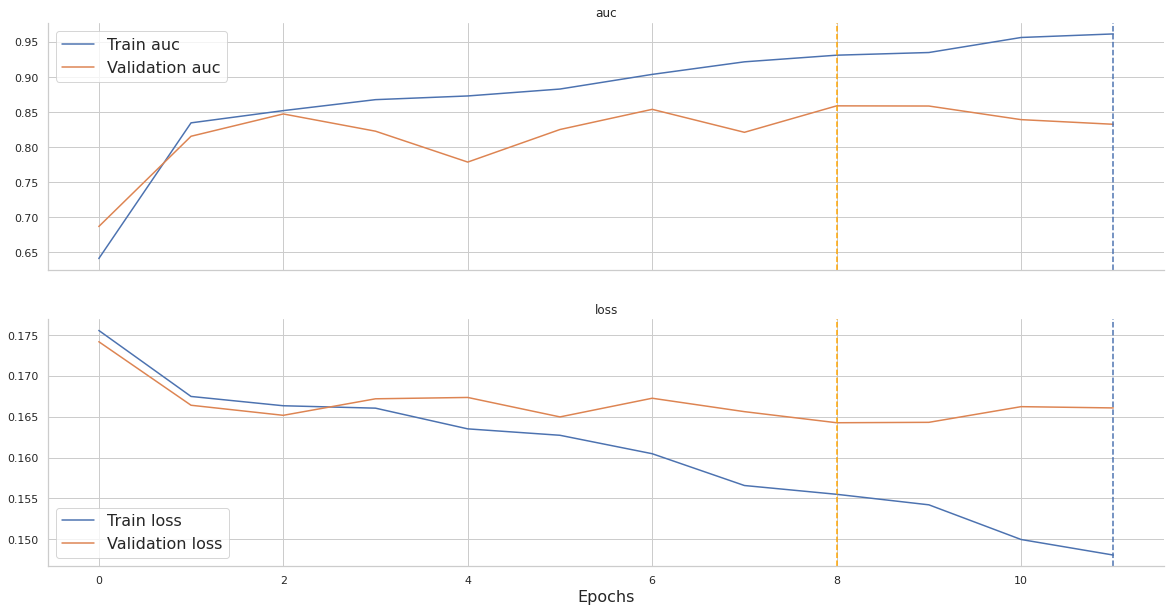

Fold: 2


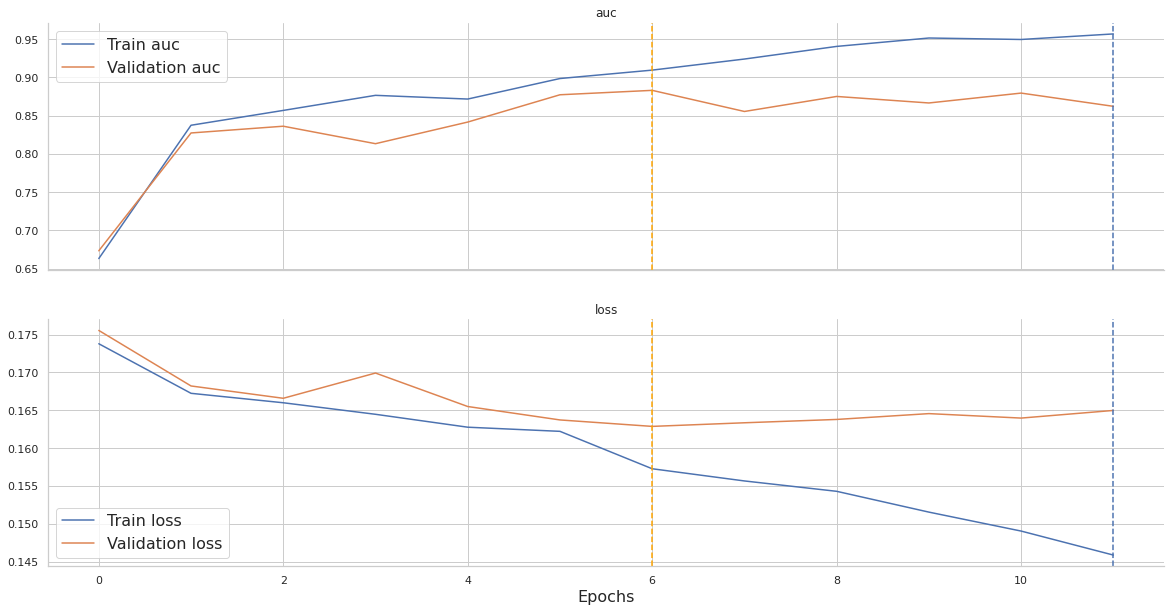

Fold: 3


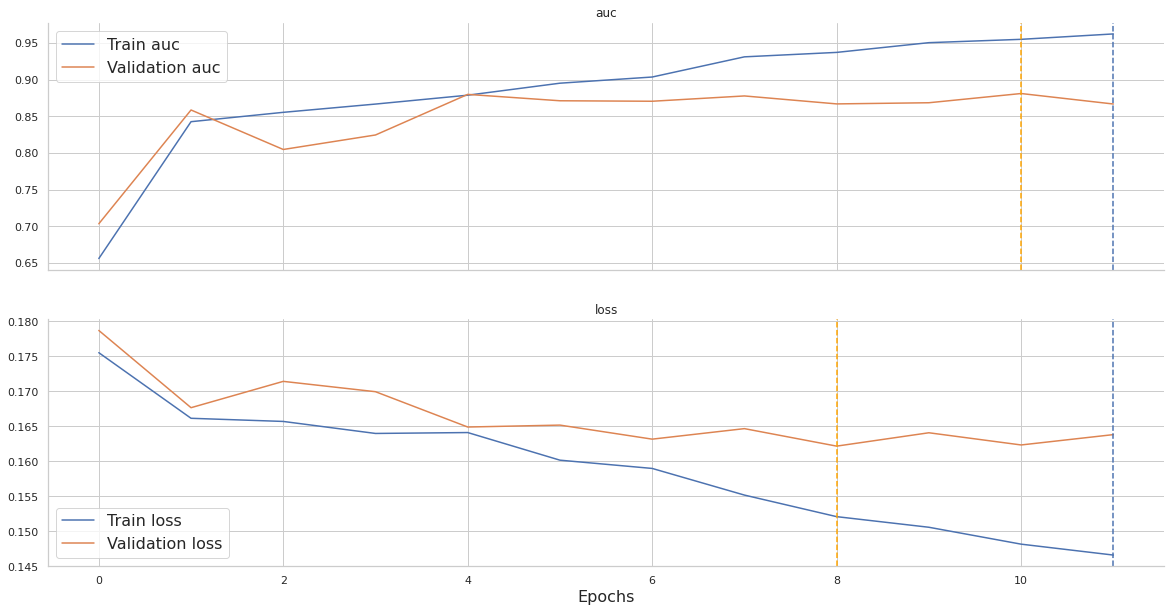

Fold: 4


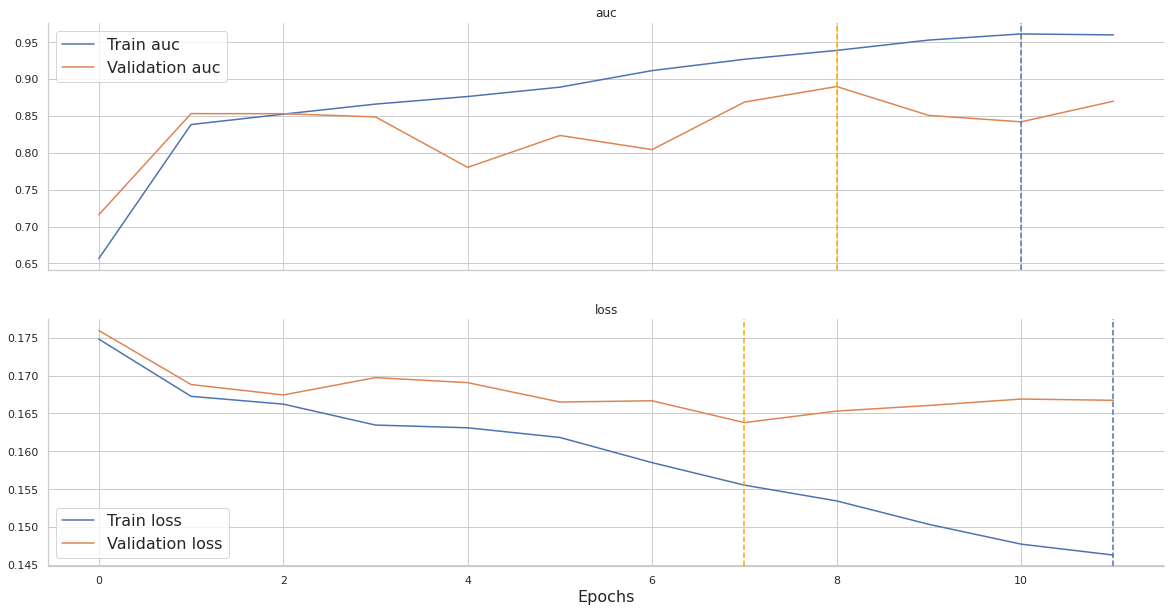

Fold: 5


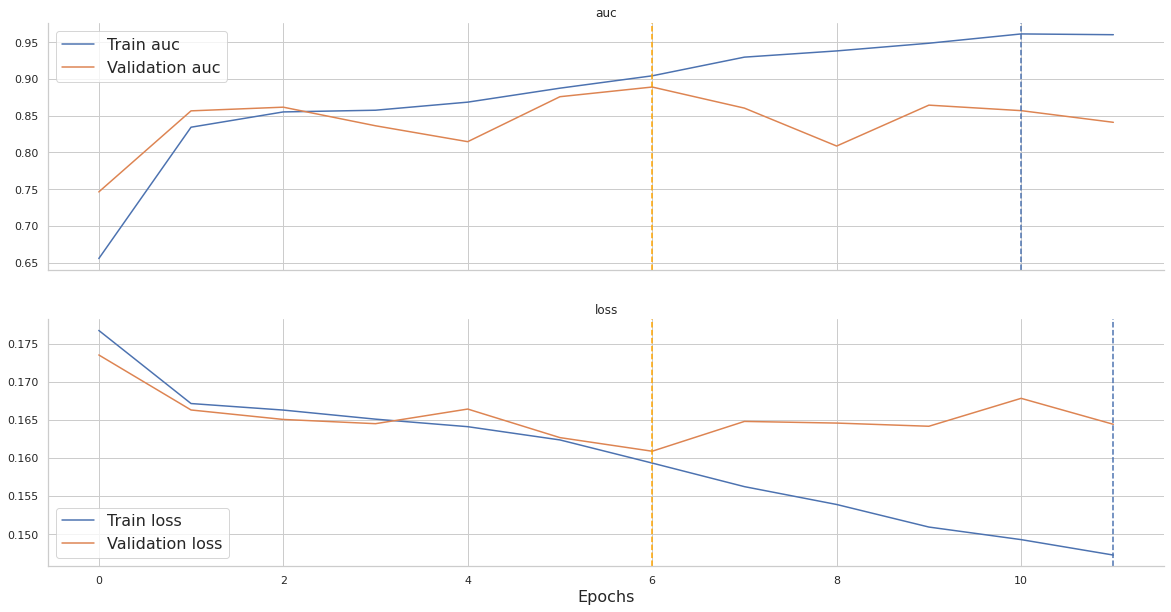

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

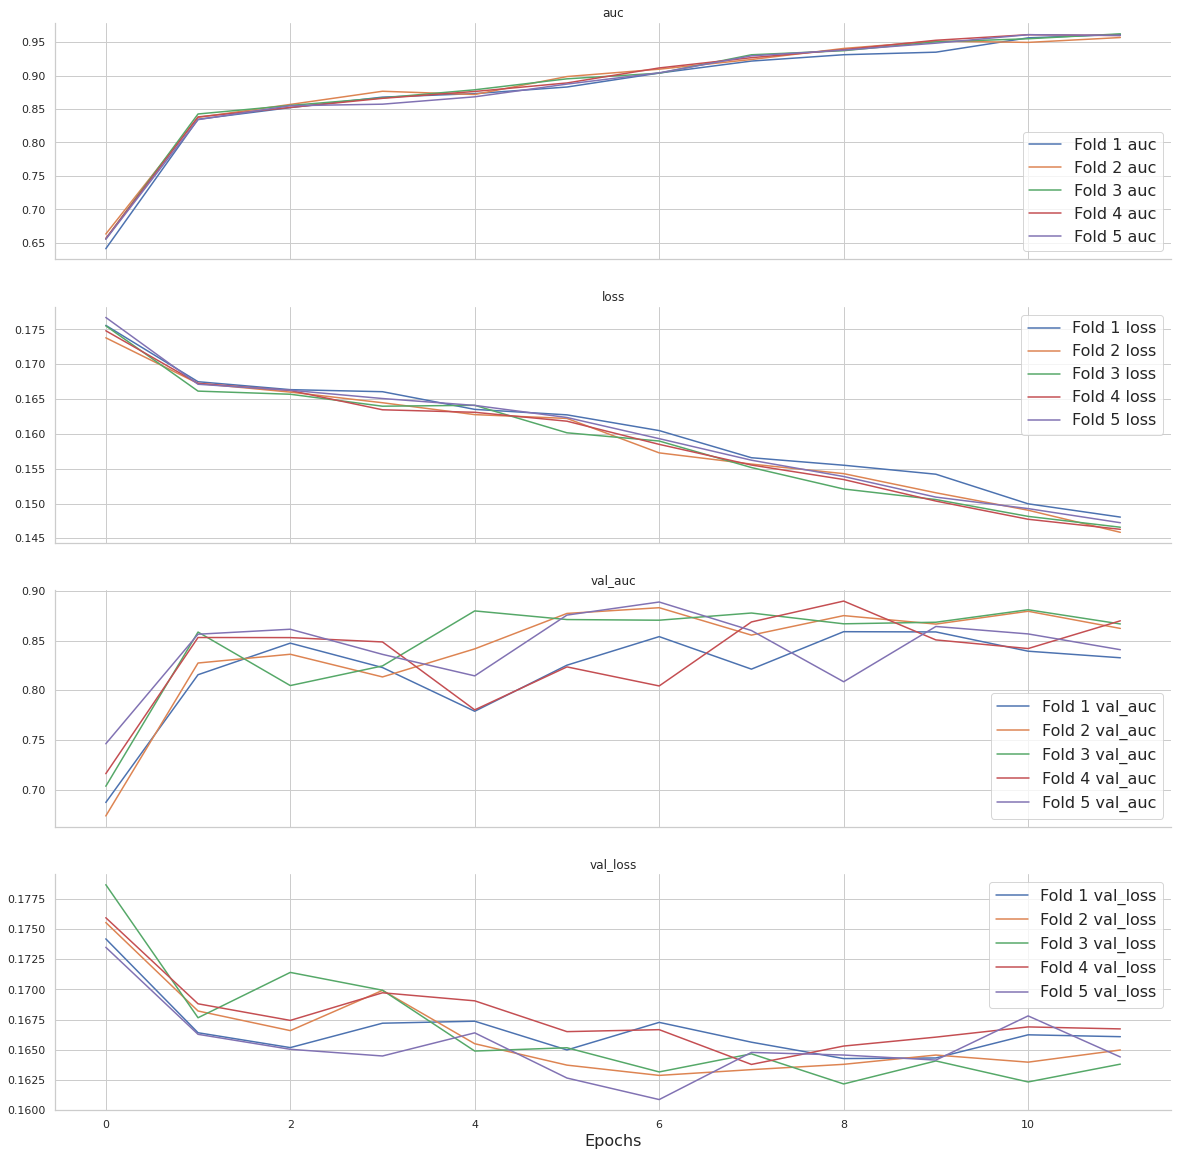

In [20]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [21]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.988046,0.855425,0.132621,0.990551,0.836321,0.985196,0.860172,0.985046,0.870252,0.990367,0.868752,0.989070,0.841628
Accuracy,0.992155,0.981372,0.010783,0.991909,0.981893,0.991974,0.980686,0.992494,0.981169,0.993054,0.981138,0.991342,0.981973
Precision,0.917794,0.417170,0.500624,0.965385,0.408163,0.868571,0.400000,0.911315,0.458333,0.920354,0.419355,0.923345,0.400000
Recall,0.611676,0.141700,0.469976,0.566591,0.141844,0.641350,0.181818,0.632696,0.194690,0.661017,0.116071,0.556723,0.074074
F1-score,0.732572,0.208127,0.524445,0.714083,0.210526,0.737864,0.250000,0.746867,0.273292,0.769420,0.181818,0.694626,0.125000
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [22]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.988046,0.855425,0.132621,0.990551,0.836321,0.985196,0.860172,0.985046,0.870252,0.990367,0.868752,0.989070,0.841628
male,0.990035,0.874675,0.115360,0.992642,0.854169,0.987488,0.864200,0.987845,0.898550,0.990661,0.888342,0.991540,0.868114
female,0.984661,0.821056,0.163605,0.986637,0.808551,0.981613,0.844809,0.980685,0.802638,0.989545,0.842221,0.984825,0.807060
head/neck,0.987109,0.868894,0.118215,0.982030,0.861395,0.978908,0.810734,0.989883,0.905573,0.993792,0.858229,0.990931,0.908537
upper extremity,0.990962,0.840489,0.150473,0.991559,0.833991,0.987417,0.873960,0.991461,0.820894,0.993178,0.883833,0.991193,0.789766
lower extremity,0.982604,0.793703,0.188901,0.991319,0.743387,0.976217,0.821796,0.979189,0.836364,0.984614,0.854438,0.981681,0.712529
torso,0.988558,0.882976,0.105582,0.990357,0.887244,0.988884,0.898036,0.982138,0.883702,0.990543,0.870699,0.990867,0.875197
0 <= age < 26,0.982001,0.783276,0.198725,0.989438,0.877622,0.981926,0.704176,0.973075,0.912470,0.982841,0.886026,0.982724,0.536086
26 <= age < 40,0.990575,0.855853,0.134722,0.994398,0.865769,0.992881,0.708166,0.990656,0.867241,0.987970,0.938161,0.986970,0.899929


# Model evaluation (best)

In [23]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.965621,0.875473,0.090148,0.971702,0.863608,0.956617,0.884433,0.977449,0.868698,0.962733,0.871310,0.959601,0.889315
Accuracy,0.987344,0.982024,0.005320,0.988326,0.981772,0.985992,0.981812,0.988779,0.982778,0.987371,0.981461,0.986252,0.982295
Precision,0.870358,0.459517,0.410841,0.913514,0.352941,0.801242,0.428571,0.947090,0.650000,0.858696,0.428571,0.831250,0.437500
Recall,0.329568,0.085428,0.244140,0.381490,0.085106,0.272152,0.081818,0.380042,0.115044,0.334746,0.080357,0.279412,0.064815
F1-score,0.477377,0.143656,0.333722,0.538217,0.137143,0.406299,0.137405,0.542424,0.195489,0.481707,0.135338,0.418239,0.112903
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.965621,0.875473,0.090148,0.971702,0.863608,0.956617,0.884433,0.977449,0.868698,0.962733,0.871310,0.959601,0.889315
male,0.969343,0.881536,0.087806,0.973756,0.868567,0.961280,0.882849,0.981247,0.886210,0.967811,0.875833,0.962619,0.894224
female,0.959053,0.860384,0.098669,0.967409,0.852382,0.949853,0.875238,0.971995,0.826663,0.953023,0.863267,0.952984,0.884369
head/neck,0.961734,0.847886,0.113848,0.959111,0.805233,0.942077,0.860713,0.979949,0.849226,0.970124,0.870855,0.957407,0.853404
upper extremity,0.964914,0.874189,0.090725,0.968516,0.884004,0.953014,0.872965,0.979546,0.849969,0.961160,0.881749,0.962336,0.882258
lower extremity,0.959330,0.824259,0.135071,0.972147,0.801443,0.955629,0.850020,0.963783,0.855995,0.945794,0.835265,0.959297,0.778573
torso,0.968596,0.904290,0.064306,0.974102,0.917414,0.959698,0.923681,0.981692,0.876299,0.968135,0.873179,0.959352,0.930877
0 <= age < 26,0.942789,0.794299,0.148489,0.963182,0.836364,0.945172,0.745360,0.942195,0.845923,0.931168,0.838865,0.932227,0.704985
26 <= age < 40,0.960859,0.851640,0.109219,0.968397,0.880335,0.969540,0.759222,0.976757,0.854414,0.962202,0.805893,0.927398,0.958333


# Confusion matrix

Fold: 1


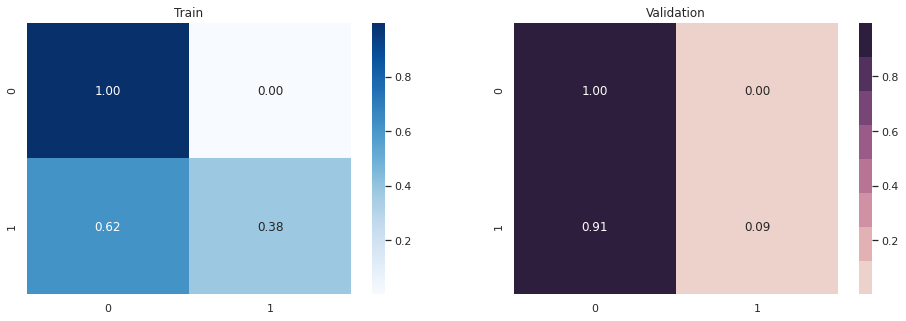

Fold: 2


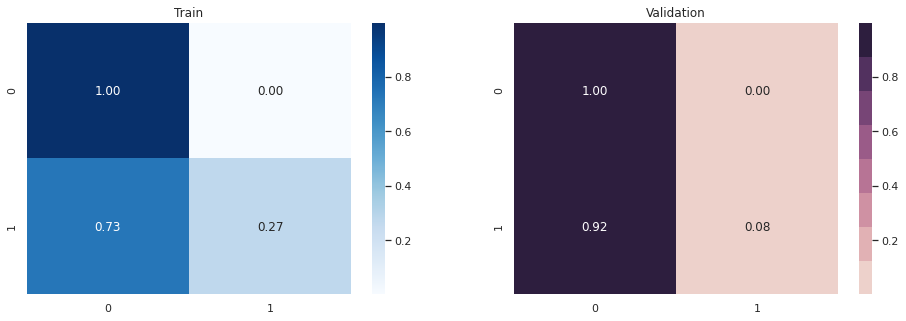

Fold: 3


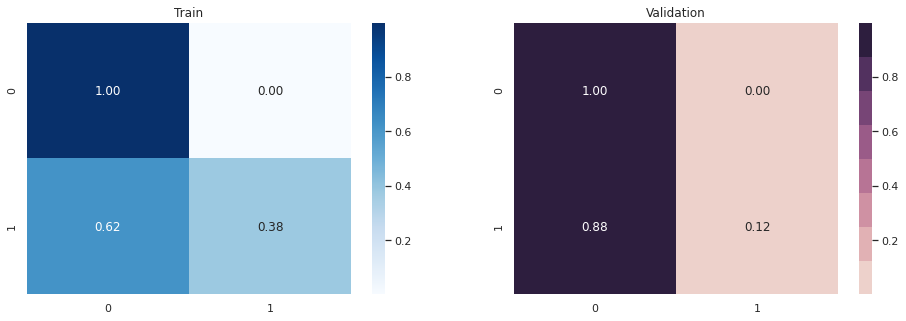

Fold: 4


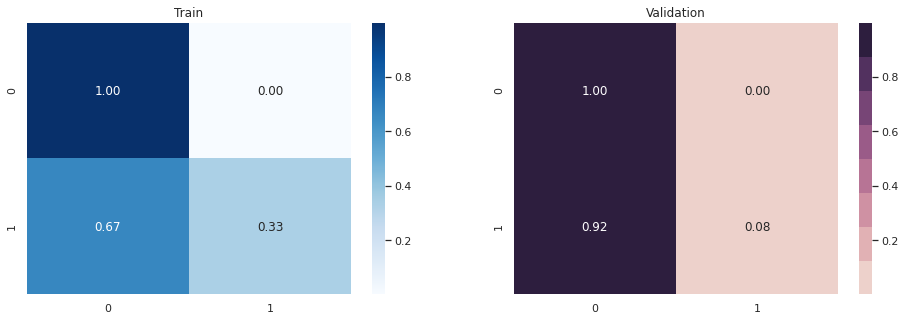

Fold: 5


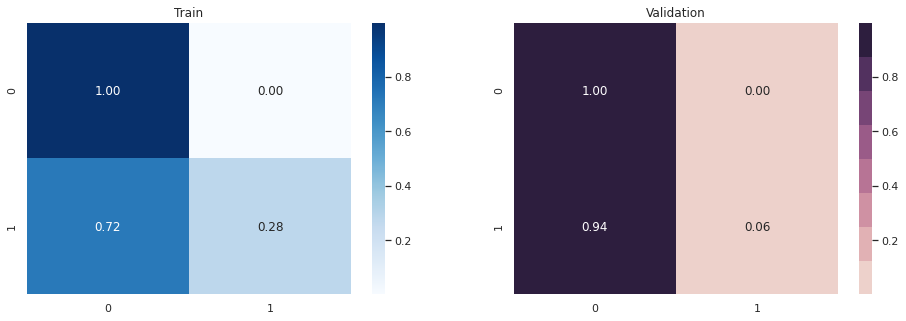

In [24]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [25]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 353
Train positive correct predictions: 344
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.028758,0.014677,0.060686,0.020686,0.017610,0.030131
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.027610,0.022032,0.030791,0.026381,0.031861,0.026986
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.024202,0.025855,0.023501,0.024235,0.021306,0.026113
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.025037,0.016914,0.016757,0.036349,0.027039,0.028126
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.026707,0.023393,0.030814,0.028418,0.024573,0.026334
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.029788,0.029229,0.024762,0.032835,0.025408,0.036706
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.025938,0.012710,0.025362,0.039283,0.033472,0.018866
7,ISIC_0075663,female,35.0,torso,unknown,0,0.026512,0.017850,0.019477,0.049011,0.021696,0.024525
8,ISIC_0075914,male,30.0,torso,unknown,0,0.027553,0.037829,0.018229,0.026289,0.030399,0.025018
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.028377,0.047218,0.021740,0.026087,0.023739,0.023101


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.317553,0.025494,0.153865,0.919451,0.090018,0.398937
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.691169,0.054256,0.737227,0.839947,0.969807,0.854606
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.507802,0.305881,0.662739,0.080430,0.771474,0.718488
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.066003,0.022602,0.034593,0.078407,0.074077,0.120338
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.398614,0.032781,0.388880,0.307025,0.968376,0.296008
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.545535,0.982835,0.433368,0.820384,0.207236,0.283853
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.546024,0.588668,0.107054,0.471268,0.980722,0.582407
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.678710,0.069955,0.957734,0.660834,0.713206,0.991820
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.142247,0.059979,0.138667,0.058177,0.338063,0.116351
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.246697,0.131606,0.489213,0.038970,0.242232,0.331463


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.691169,0.054256,0.737227,0.839947,0.969807,0.854606
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.507802,0.305881,0.662739,0.080430,0.771474,0.718488
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.545535,0.982835,0.433368,0.820384,0.207236,0.283853
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.546024,0.588668,0.107054,0.471268,0.980722,0.582407
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.678710,0.069955,0.957734,0.660834,0.713206,0.991820
580,ISIC_0280912,male,70.0,torso,melanoma,1,0.659180,0.048366,0.821506,0.989809,0.997952,0.438268
707,ISIC_0314462,male,80.0,torso,unknown,0,0.574682,0.167693,0.650771,0.410332,0.798730,0.845884
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.998023,0.997572,0.998696,0.998277,0.995644,0.999928
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.651982,0.086113,0.595643,0.829619,0.987319,0.761216
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.848700,0.405068,0.980811,0.959664,0.963276,0.934681


# Visualize test predictions

In [26]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 28|10954
Test predictions (last) 61|10921
Test predictions (tta) 15|10967
Test predictions (last tta) 56|10926
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.026688,0.023896,0.026711,0.023120
1,ISIC_0052349,male,40.0,lower extremity,0.025518,0.024658,0.027441,0.026349
2,ISIC_0058510,female,55.0,torso,0.019690,0.022580,0.024779,0.025539
3,ISIC_0073313,female,50.0,torso,0.021301,0.025228,0.022627,0.025836
4,ISIC_0073502,female,45.0,lower extremity,0.042068,0.023967,0.049211,0.042096
5,ISIC_0074618,male,50.0,lower extremity,0.029752,0.024547,0.033435,0.026847
6,ISIC_0076801,male,45.0,upper extremity,0.025821,0.024918,0.028029,0.032136
7,ISIC_0077586,male,50.0,lower extremity,0.040994,0.035117,0.043827,0.037079
8,ISIC_0082004,female,45.0,torso,0.029893,0.029361,0.036089,0.037726
9,ISIC_0082785,male,65.0,lower extremity,0.027807,0.020971,0.028440,0.022957


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
403,ISIC_0481105,male,80.0,torso,0.848634,0.972476,0.800763,0.979998
522,ISIC_0585534,male,70.0,head/neck,0.507074,0.761799,0.453465,0.485498
943,ISIC_0936377,male,65.0,head/neck,0.571914,0.482771,0.561346,0.471222
951,ISIC_0945202,male,45.0,NaN,0.508323,0.608402,0.324226,0.356196
1485,ISIC_1429763,male,45.0,head/neck,0.502678,0.920261,0.352750,0.716085
1677,ISIC_1593714,female,50.0,lower extremity,0.745134,0.937281,0.584206,0.951948
2195,ISIC_2078598,male,80.0,torso,0.547289,0.608350,0.415147,0.639829
2646,ISIC_2481946,female,75.0,torso,0.553255,0.890544,0.319201,0.545227
2739,ISIC_2560699,male,70.0,torso,0.882587,0.964710,0.902953,0.928041
3045,ISIC_2839742,male,70.0,upper extremity,0.953339,0.997764,0.964749,0.997109


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
109,ISIC_0216447,male,80.0,head/neck,0.449779,0.569571,0.497734,0.632988
403,ISIC_0481105,male,80.0,torso,0.848634,0.972476,0.800763,0.979998
522,ISIC_0585534,male,70.0,head/neck,0.507074,0.761799,0.453465,0.485498
533,ISIC_0591142,male,60.0,head/neck,0.220389,0.533651,0.106507,0.110640
552,ISIC_0606244,male,70.0,torso,0.268197,0.546126,0.156164,0.392937
951,ISIC_0945202,male,45.0,NaN,0.508323,0.608402,0.324226,0.356196
1069,ISIC_1030252,female,50.0,head/neck,0.298668,0.539640,0.242991,0.360667
1334,ISIC_1294368,female,35.0,torso,0.355301,0.606443,0.293223,0.630437
1485,ISIC_1429763,male,45.0,head/neck,0.502678,0.920261,0.352750,0.716085
1677,ISIC_1593714,female,50.0,lower extremity,0.745134,0.937281,0.584206,0.951948


# Test set predictions

In [27]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.026688,0.023896,0.025292,0.026711,0.023120,0.024915
1,ISIC_0052349,0.025518,0.024658,0.025088,0.027441,0.026349,0.026895
2,ISIC_0058510,0.019690,0.022580,0.021135,0.024779,0.025539,0.025159
3,ISIC_0073313,0.021301,0.025228,0.023265,0.022627,0.025836,0.024231
4,ISIC_0073502,0.042068,0.023967,0.033018,0.049211,0.042096,0.045654
5,ISIC_0074618,0.029752,0.024547,0.027149,0.033435,0.026847,0.030141
6,ISIC_0076801,0.025821,0.024918,0.025369,0.028029,0.032136,0.030082
7,ISIC_0077586,0.040994,0.035117,0.038055,0.043827,0.037079,0.040453
8,ISIC_0082004,0.029893,0.029361,0.029627,0.036089,0.037726,0.036907
9,ISIC_0082785,0.027807,0.020971,0.024389,0.028440,0.022957,0.025699


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.040969,0.042544,0.041756,0.040549,0.042977,0.041763
std,0.047349,0.064682,0.054832,0.042439,0.061791,0.051121
min,0.016964,0.013822,0.016885,0.017993,0.015704,0.016849
25%,0.025816,0.024900,0.025574,0.026172,0.025297,0.025888
50%,0.029665,0.027916,0.028697,0.029908,0.027925,0.028832
75%,0.038378,0.034806,0.036808,0.038431,0.035844,0.037278
max,0.953339,0.997764,0.975551,0.964749,0.997109,0.980929
